In [153]:
#Importe de las librerías a usar
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from datetime import date
import seaborn as sns

In [154]:
#Extraigo los libros a utilizar en df
archivo = 'homicidios.xlsx'
df_victimas = pd.read_excel(archivo, sheet_name='VICTIMAS')
df_hechos = pd.read_excel(archivo, 'HECHOS')

In [155]:
df_victimas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717 entries, 0 to 716
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID_hecho             717 non-null    object        
 1   FECHA                717 non-null    datetime64[ns]
 2   AAAA                 717 non-null    int64         
 3   MM                   717 non-null    int64         
 4   DD                   717 non-null    int64         
 5   ROL                  717 non-null    object        
 6   VICTIMA              717 non-null    object        
 7   SEXO                 717 non-null    object        
 8   EDAD                 717 non-null    object        
 9   FECHA_FALLECIMIENTO  717 non-null    object        
dtypes: datetime64[ns](1), int64(3), object(6)
memory usage: 56.1+ KB


In [156]:
df_hechos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 696 entries, 0 to 695
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   ID                     696 non-null    object        
 1   N_VICTIMAS             696 non-null    int64         
 2   FECHA                  696 non-null    datetime64[ns]
 3   AAAA                   696 non-null    int64         
 4   MM                     696 non-null    int64         
 5   DD                     696 non-null    int64         
 6   HORA                   696 non-null    object        
 7   HH                     696 non-null    object        
 8   LUGAR_DEL_HECHO        696 non-null    object        
 9   TIPO_DE_CALLE          696 non-null    object        
 10  Calle                  695 non-null    object        
 11  Altura                 129 non-null    float64       
 12  Cruce                  525 non-null    object        
 13  Direc

In [157]:
#renombramos la columna ID_hecho para usarla como parametro
df_victimas=df_victimas.rename(columns={'ID_hecho':'ID'})

In [158]:
combinado = df_hechos.merge(df_victimas, on='ID', how='inner')

### Al haber datos repetidos se verifica cuales son y son eliminados:

In [159]:
def encontrar_columnas_diferentes(df):

    columnas_diferentes = []
    columnas_iguales = []

    for columna1 in df.columns:
        for columna2 in df.columns:
            if columna1 != columna2:
                if (df[columna1] == df[columna2]).all():
                    columnas_iguales.append((columna1, columna2))
                elif not (df[columna1] == df[columna2]).all():
                    columnas_diferentes.append((columna1, columna2))

    return columnas_iguales, columnas_diferentes

# Ejemplo de uso con tus columnas
columnas_iguales, columnas_diferentes = encontrar_columnas_diferentes(combinado[combinado.columns])

print("Pares de columnas iguales:")
for columna1, columna2 in columnas_iguales:
    print(f"{columna1} y {columna2} son iguales")

Pares de columnas iguales:
AAAA_x y AAAA_y son iguales
MM_x y MM_y son iguales
AAAA_y y AAAA_x son iguales
MM_y y MM_x son iguales


In [160]:
# Se encontraron 2 columnas con el mismo contenido, se realiza el drop a una de ellas:
combinado = combinado.drop(['AAAA_y','MM_y'],axis=1)

In [161]:
# Sin embargo entre las columnas de los dataframes existian otras columnas con el mismo nombre, así que se comprueba qué es lo que esta causando estas diferencias,
# para eso se crea una función que devuelve los índices con anomalias.

indices=[]
for index, row  in combinado[['FECHA_x','FECHA_y', 'DD_x','DD_y', 'VICTIMA_x',  'VICTIMA_y']].iterrows():

    if row['FECHA_x'] !=row['FECHA_y']:
        indices.append(index)


    if row['DD_x'] !=row['DD_y']:
        indices.append(index)
    if row['VICTIMA_x'] !=row['VICTIMA_y']:
        indices.append(index)

In [162]:
# Se muestran solo los indices y las columnas que deberian ser iguales, esto, en los indices que arrojó la funcion.
combinado[['FECHA_x','FECHA_y', 'DD_x','DD_y', 'VICTIMA_x','ACUSADO',  'VICTIMA_y','FECHA_FALLECIMIENTO' ]].iloc[indices]

,FECHA_x,FECHA_y,DD_x,DD_y,VICTIMA_x,ACUSADO,VICTIMA_y,FECHA_FALLECIMIENTO
65,2016-07-02,2016-07-03,3,3,MOTO,OBJETO FIJO,MOTO,2016-07-03 00:00:00
204,2017-05-24,2017-05-29,24,29,MOTO,SD,MOTO,2017-05-29 00:00:00
204,2017-05-24,2017-05-29,24,29,MOTO,SD,MOTO,2017-05-29 00:00:00
237,2017-09-02,2017-09-02,2,2,OBJETO FIJO,AUTO,AUTO,2017-09-02 00:00:00
238,2017-09-02,2017-09-02,2,2,OBJETO FIJO,AUTO,AUTO,2017-09-02 00:00:00
602,2020-12-05,2020-12-05,5,5,PEATON_MOTO,MOTO,PEATON,2020-12-05 00:00:00
603,2020-12-05,2020-12-05,5,5,PEATON_MOTO,MOTO,MOTO,2020-12-05 00:00:00


In [163]:
# Entre las fechas encontramos que hay ciertas diferencias porque al parecer en la columna fecha proviniente de el archivo victimas corresponde a la fecha de fallecimiento 
#y no a la fecha del suceso, por lo tanto decido quedarme la fecha que de verdad es relevante para el estudio actual que es la fecha del suceso.
combinado = combinado.drop(['FECHA_y','DD_y'],axis=1)

In [164]:
# Verificando los valores distintos para las columnas victimas vemos que en la columna vctima proviniente del archivo hechos se da por victima a un objeto fijo y 
#por acusado a un AUTO lo que es incoherente con la definicion de victima dada por el dataset es la siguente: Vehículo que ocupaba quien haya fallecido a se haya 
#lastimado a raíz del hecho, o bien peatón/a. Clasificación agregada del tipo de vehículos.
#y en el apartado de victima no esta definido el objeto fijo como una victima posible
combinado[combinado['VICTIMA_x']=='OBJETO FIJO']

,ID,N_VICTIMAS,FECHA_x,AAAA_x,MM_x,DD_x,HORA,HH,LUGAR_DEL_HECHO,TIPO_DE_CALLE,...,pos x,pos y,PARTICIPANTES,VICTIMA_x,ACUSADO,ROL,VICTIMA_y,SEXO,EDAD,FECHA_FALLECIMIENTO
237,2017-0108,2,2017-09-02,2017,9,2,04:53:08,4,AV. GRAL. PAZ Y MACHAIN,GRAL PAZ,...,-58.49491054,-34.54795581,AUTO-OBJETO FIJO,OBJETO FIJO,AUTO,PASAJERO_ACOMPAÑANTE,AUTO,MASCULINO,17,2017-09-02 00:00:00
238,2017-0108,2,2017-09-02,2017,9,2,04:53:08,4,AV. GRAL. PAZ Y MACHAIN,GRAL PAZ,...,-58.49491054,-34.54795581,AUTO-OBJETO FIJO,OBJETO FIJO,AUTO,PASAJERO_ACOMPAÑANTE,AUTO,MASCULINO,10,2017-09-02 00:00:00


In [165]:
# Esto solo pasa para este hecho asi que se confirma que se debe a un error por lo que se procedera a corregirse
def columns_modifier(mode,DF,columns, value, replace=None):
    df=DF.copy()
    if mode == 'swap':
        for index, row in df.iterrows():

            value_1=row[columns[0]]
            value_2=row[columns[1]]

            if value_1== value:
                temp=value_1
                df.at[index, columns[0]] = value_2
                df.at[index, columns[1]] = temp
    if mode == 'replace':
        for index, row in df.iterrows():
            to_replace=row[columns[0]]

            if to_replace == value:
                df.at[index, columns[0]] = replace
    
    return df

In [166]:
columns=['VICTIMA_x','ACUSADO']
combinado=columns_modifier('swap',combinado,columns,'OBJETO FIJO')

In [167]:
combinado[['FECHA_x', 'DD_x', 'VICTIMA_x','ACUSADO',  'VICTIMA_y','FECHA_FALLECIMIENTO' ]].iloc[indices]

,FECHA_x,DD_x,VICTIMA_x,ACUSADO,VICTIMA_y,FECHA_FALLECIMIENTO
65,2016-07-02,3,MOTO,OBJETO FIJO,MOTO,2016-07-03 00:00:00
204,2017-05-24,24,MOTO,SD,MOTO,2017-05-29 00:00:00
204,2017-05-24,24,MOTO,SD,MOTO,2017-05-29 00:00:00
237,2017-09-02,2,AUTO,OBJETO FIJO,AUTO,2017-09-02 00:00:00
238,2017-09-02,2,AUTO,OBJETO FIJO,AUTO,2017-09-02 00:00:00
602,2020-12-05,5,PEATON_MOTO,MOTO,PEATON,2020-12-05 00:00:00
603,2020-12-05,5,PEATON_MOTO,MOTO,MOTO,2020-12-05 00:00:00


In [168]:
indices=[]
for index, row  in combinado[['VICTIMA_x', 'VICTIMA_y']].iterrows():

    if row['VICTIMA_x'] !=row['VICTIMA_y']:
        indices.append(index)
indices

[602, 603]

In [169]:
combinado[[ 'VICTIMA_x',  'VICTIMA_y']].iloc[indices]

,VICTIMA_x,VICTIMA_y
602,PEATON_MOTO,PEATON
603,PEATON_MOTO,MOTO


In [170]:
# Ahora, ya que los únicos registros que son distintos en estas columnas son estos y podemos ver que una columna repite la misma información dos veces mientras 
# que la otra nos aporta informacion sobre cada victima, nos quedaremos con la columna VICTIMA_y que es la mas completa.
combinado = combinado.drop(['VICTIMA_x'],axis=1)

In [171]:
combinado.columns


Index(['ID', 'N_VICTIMAS', 'FECHA_x', 'AAAA_x', 'MM_x', 'DD_x', 'HORA', 'HH',
       'LUGAR_DEL_HECHO', 'TIPO_DE_CALLE', 'Calle', 'Altura', 'Cruce',
       'Dirección Normalizada', 'COMUNA', 'XY (CABA)', 'pos x', 'pos y',
       'PARTICIPANTES', 'ACUSADO', 'ROL', 'VICTIMA_y', 'SEXO', 'EDAD',
       'FECHA_FALLECIMIENTO'],
      dtype='object')

In [172]:
combinado = combinado.rename(columns={'FECHA_x':'FECHA', 'AAAA_x':'AAAA', 'MM_x':'MM', 'DD_x':'DD', 'pos x':'Longitud','pos y':'Latitud', 'VICTIMA_y':'VICTIMA'})

In [173]:
#Revisando la columna numero de victimas se encuentra una incongruencia debido al merge ya que el numero de victimas total deberia ser 717 vicitmas
#ya que esa es la  cantidad de registros en el archivo victimas
combinado['N_VICTIMAS'].sum()

761

In [174]:
#vemos que para solucionar esto basta con igualar la columna siempre a 1
combinado['N_VICTIMAS']=1

In [175]:
combinado['N_VICTIMAS'].sum()

717

In [176]:
def encontrar_valores(df, valor_a_encontrar):
    resultados = []
    
    for columna in df.columns:
        columnas_con_valores = []
        indices_con_valores = []

        for indice, valor in df[columna].items():
            if valor == valor_a_encontrar:
                columnas_con_valores.append(columna)
                indices_con_valores.append(indice)
        
        if columnas_con_valores:
            resultados.append({
                'Columna': columna,
                'Indices': indices_con_valores
            })
    
    return resultados

In [177]:
columnasSD=encontrar_valores(combinado, 'SD')
columnasSD

[{'Columna': 'HORA', 'Indices': [536]},
 {'Columna': 'HH', 'Indices': [536]},
 {'Columna': 'LUGAR_DEL_HECHO', 'Indices': [121]},
 {'Columna': 'ACUSADO',
  'Indices': [3,
   33,
   36,
   39,
   58,
   77,
   84,
   93,
   107,
   114,
   121,
   128,
   141,
   162,
   204,
   208,
   223,
   409,
   413,
   457,
   468,
   475,
   641]},
 {'Columna': 'ROL',
  'Indices': [36, 39, 63, 77, 89, 141, 167, 208, 221, 280, 390]},
 {'Columna': 'VICTIMA', 'Indices': [36, 77, 89, 93, 141, 167, 208, 221, 280]},
 {'Columna': 'SEXO', 'Indices': [36, 39, 108, 121, 138, 141]},
 {'Columna': 'EDAD',
  'Indices': [30,
   33,
   35,
   36,
   39,
   55,
   63,
   72,
   89,
   93,
   108,
   119,
   121,
   138,
   141,
   142,
   165,
   176,
   182,
   225,
   243,
   275,
   277,
   299,
   328,
   359,
   367,
   371,
   377,
   391,
   421,
   444,
   446,
   454,
   457,
   461,
   463,
   469,
   478,
   497,
   505,
   528,
   529,
   548,
   552,
   555,
   563,
   572,
   579,
   631,
   639,
 

In [178]:
columna=['HH']
combinado=columns_modifier('replace',combinado,columna,'SD',np.nan)

In [179]:
columna=['HORA']
combinado=columns_modifier('replace',combinado,columna,'SD',np.nan)

In [180]:
#Hasta ahora ya no hay valores SD en las columnas HORA Y HH puesto que fueron reemplazados por NaN. Ahora podriamos imputar estos valores. 

def convertir_hora(decimal_hora):
    # Extraer la parte entera y decimal de la hora
    horas_enteras = int(decimal_hora)
    minutos_decimales = (decimal_hora - horas_enteras) * 60

    # Formatear como cadena de tiempo (HH:MM)
    hora_formateada = f"{horas_enteras:02d}:{int(minutos_decimales):02d}"

    return hora_formateada

In [181]:
combinado['HORA']=combinado['HORA'].fillna(convertir_hora(combinado['HH'].mean()))
combinado['HH']=combinado['HH'].fillna(combinado['HH'].mean()).apply(int)

C:\Users\Manuel\AppData\Local\Temp\ipykernel_18316\1850273448.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  combinado['HH']=combinado['HH'].fillna(combinado['HH'].mean()).apply(int)


In [182]:
#Verificamos si los resultados son correctos.
combinado.iloc[514]

ID                                                    2019-0080
N_VICTIMAS                                                    1
FECHA                                       2019-09-17 00:00:00
AAAA                                                       2019
MM                                                            9
DD                                                           17
HORA                                        1900-01-04 18:40:00
HH                                                           18
LUGAR_DEL_HECHO                    CABILDO AV. y PAZ, GRAL. AV.
TIPO_DE_CALLE                                          GRAL PAZ
Calle                                               CABILDO AV.
Altura                                                      NaN
Cruce                                            PAZ, GRAL. AV.
Dirección Normalizada              CABILDO AV. y PAZ, GRAL. AV.
COMUNA                                                       13
XY (CABA)                Point (98817.74

In [183]:
#Modificamos unos valores que no estan correctamente definidos en Hora
combinado.iloc[459, combinado.columns.get_loc('HORA')]="07:12:00"
combinado.iloc[457, combinado.columns.get_loc('HORA')]="00:00:00"
combinado.iloc[514, combinado.columns.get_loc('HORA')]="18:40:00"

In [184]:
combinado=columns_modifier('replace',combinado,['EDAD'],'SD',np.nan)

In [185]:
combinado.iloc[459, combinado.columns.get_loc('HORA')]="07:12:00"

In [186]:
combinado.to_csv('Para_dashboard/Datos_homicidios.csv', index=False)

# Relacion AAAA - N_VICTIMAS

<Axes: xlabel='AAAA'>

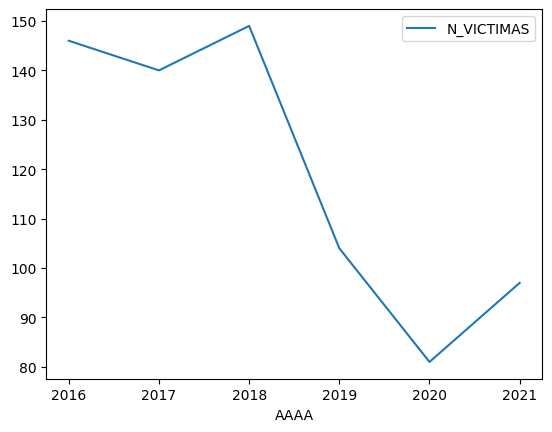

In [187]:
victimas_por_fecha = combinado.groupby('AAAA')['N_VICTIMAS'].count().reset_index()
victimas_por_fecha=victimas_por_fecha.set_index('AAAA')
victimas_por_fecha.plot()

se observa un minimo relativo en el año 2020 lo que se le podria abjudicar al aislamiento producido por la pandemia de covid 19 sin embargo la tendencia bajista parece provenir de años anteriores a la pandemia alcanzandose el minimo en el 2020

# Relacion COMUNA - N_VICTIMAS

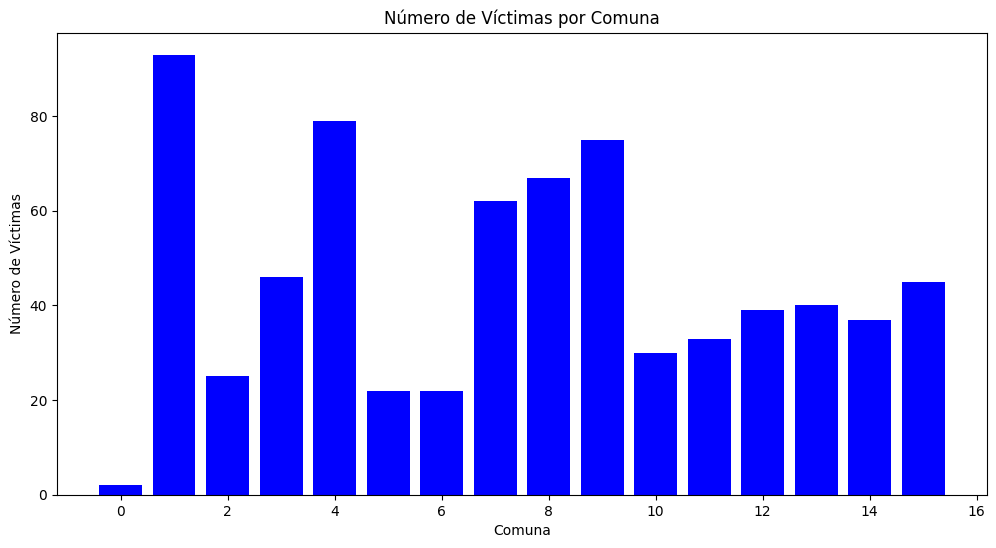

In [188]:
victimas_por_comuna = combinado.groupby('COMUNA')['N_VICTIMAS'].sum().reset_index()
plt.figure(figsize=(12, 6))
plt.bar(victimas_por_comuna['COMUNA'], victimas_por_comuna['N_VICTIMAS'], color='blue')
plt.title('Número de Víctimas por Comuna')
plt.xlabel('Comuna')
plt.ylabel('Número de Víctimas')
plt.show()

Se observa la comuna 1 como la que tiene la mayor cantidad de victimas. Le siguen la 4 y 9.

# Relacion SEXO-N_VICTIMAS

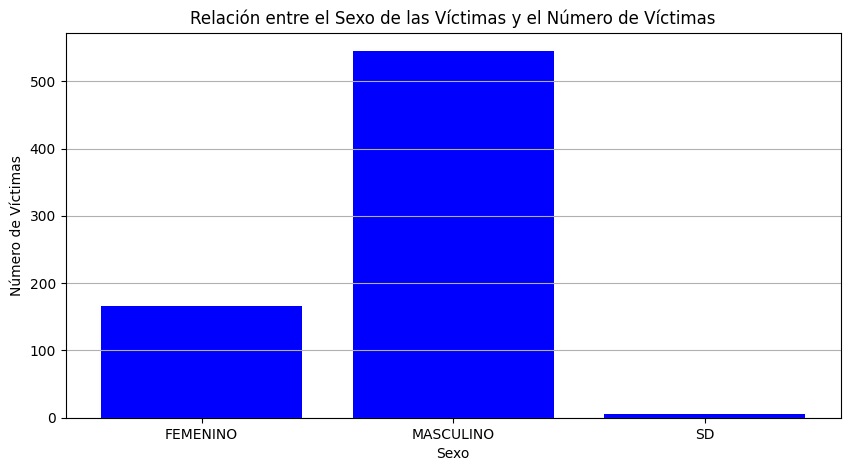

In [189]:
victimas_por_sexo = combinado.groupby('SEXO')['VICTIMA'].count().reset_index()


plt.figure(figsize=(10, 5))  
plt.bar(victimas_por_sexo['SEXO'], victimas_por_sexo['VICTIMA'], color='blue')
plt.title('Relación entre el Sexo de las Víctimas y el Número de Víctimas')
plt.xlabel('Sexo')
plt.ylabel('Número de Víctimas')
plt.grid(axis='y')


plt.show()

Se puede ver que la mayoria de muertes por accidentes de transito son de hombres

# Frecuencia de ocurrencia de los valores de la columna EDAD

c:\Users\Manuel\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
c:\Users\Manuel\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\histograms.py:826: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


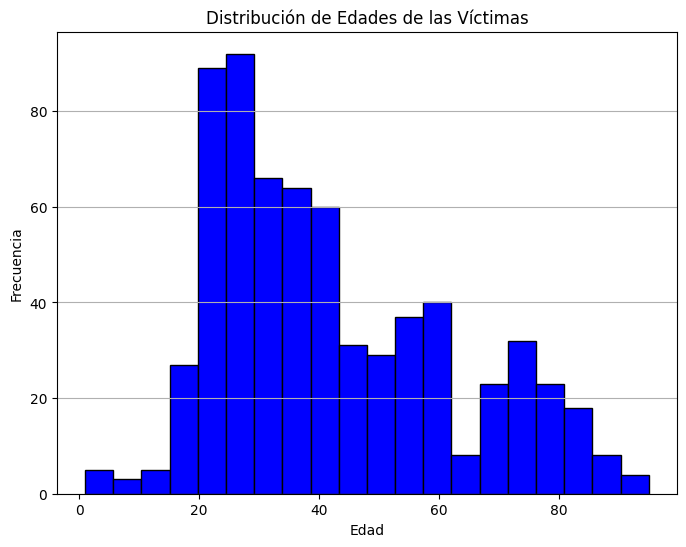

In [190]:
plt.figure(figsize=(8, 6))
plt.hist(combinado['EDAD'], bins=20, color='blue', edgecolor='black')
plt.title('Distribución de Edades de las Víctimas')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.grid(axis='y')
plt.show()

Se oberseva que el rango de edades entre los 20 y 40 años son los mas afectados pero esto puede deberse a que estas son las edades donde hay mas conductores activos, sin embargo el pico cercano a los 30 puede deberse a otras razones.

# Relacion TIPO_DE_CALLE - NUMERO DE VICTIMAS

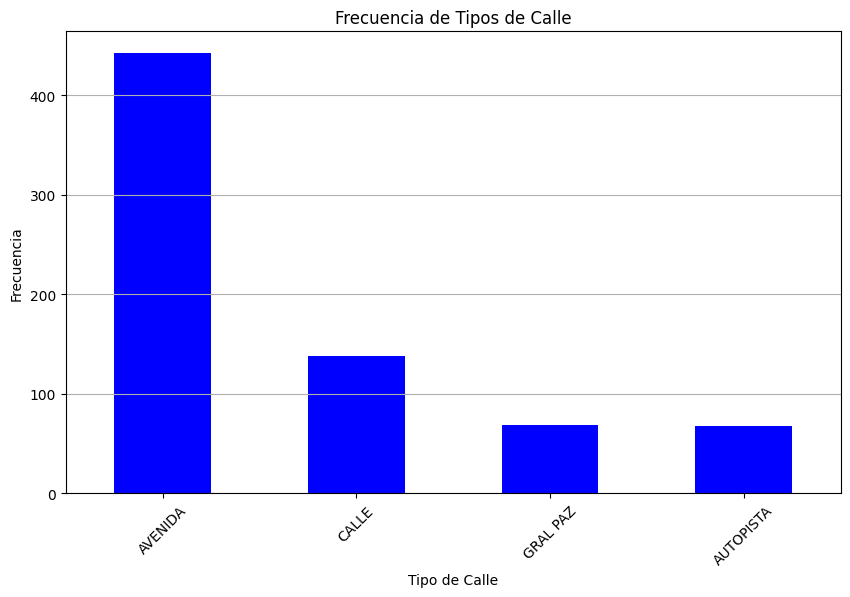

In [191]:
plt.figure(figsize=(10, 6))
combinado['TIPO_DE_CALLE'].value_counts().plot(kind='bar', color='blue')
plt.title('Frecuencia de Tipos de Calle')
plt.xlabel('Tipo de Calle')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

En las AVENIDA se dan la mayor cantidad de accidentes esto puede deberse a que las caracteristicas de esta categoria como su liminite de velocidad y amplitud presentan un ambiente optimo para la ocurrencia de siniestros viales

# Relacion MM - N_VICTIMAS

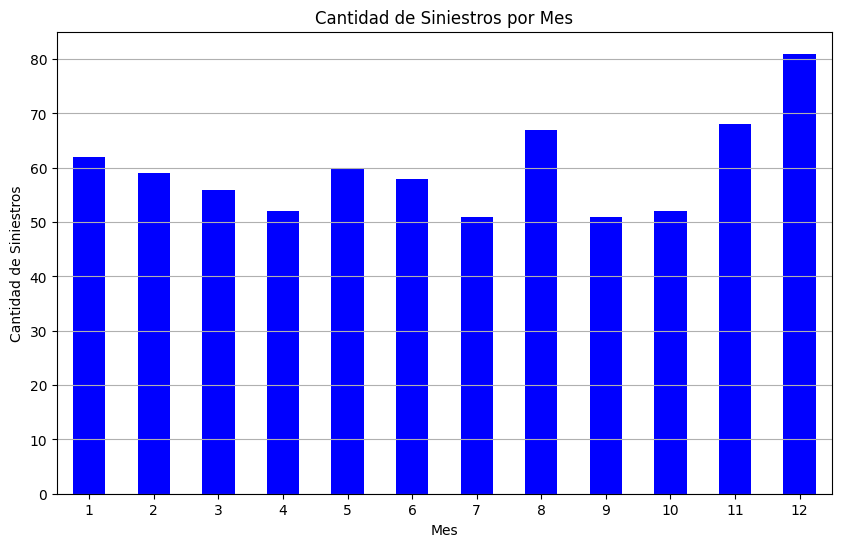

In [192]:
plt.figure(figsize=(10, 6))
combinado.groupby('MM')['N_VICTIMAS'].sum().plot(kind='bar',color='blue')
plt.title('Cantidad de Siniestros por Mes')
plt.xlabel('Mes')
plt.ylabel('Cantidad de Siniestros')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

Se observa que el mes 12  contiene la mayor cantidad de homicidios. Esto se puede deber a la cantidad de visitantes en la ciudad porque coincide con festividades